# etraChallenge_ICS Solution, Anna Agafonova, 8.1.2023

For this challenge, I explored eye tracking data. The dataset description is provided below. My initial hypothesis was: "Is the proportion of saccade to microsaccade movements a reliable predictor of visual task performance?". This hypothesis was interesting, however, there seemed to be no way to assess performance. So, I decided to explore saccades and fixation properties of eye movements with regard to the visual scene. The questions I examined were:

1. Are there differences in the number fixations and saccades between people who are asked to fixate versus those who are just freely viewing the scene? Are there differences in same measures between different stimuli?
2. Do people's saccade patterns differ depending on the type of visual scene they are viewing (e.g. blank, natural, puzzle, etc.)?
3. Do people's microsaccade patterns change as they complete a task or become more familiar with a scene?

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import *
from glob import glob
import os
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

The dataset includes data from 960 trials of 45 seconds each, collected from 8 different subjects (6 females, 2 males) that participated in 3 experimental sessions, of ~60 minutes each. Subjects performed a variety of tasks including visual fixation, visual search and visual exploration. The dataset is available for download on the following [website](https://etra.acm.org/2019/challenge.html).

In [51]:
# read in data
csv_files = sorted(glob("ETRA2019Challenge/data/**/*.csv"))

# create a dictionary of csv files and their corresponding image files
csv_image = {}
for csv_file in csv_files:
    stimulus, filename = csv_file[:-len('.csv')].split("_")[-2:] # get stimulus and filename
    image_file = f"ETRA2019Challenge/images/{stimulus.upper()}/{filename}.bmp" # create image file path
    if os.path.exists(image_file): # check if image file exists
        csv_image[csv_file] = image_file # add to dictionary

Let's take a closer look at the data to understand its structure. Our dictionary, created in a previous cell, combines all data and links each data table with eye recording data (e.g., time series of coordinates of the participant's gaze) and the image scene the participant looked at.

In [3]:
# get the first csv file and image file
csv_file = list(csv_image.keys())[0]
print(csv_file)
image_file = csv_image[csv_file]

# read in the csv file
df = pd.read_csv(csv_file)
df

ETRA2019Challenge/data/009/009_001_FreeViewing_Puzzle_puz013.csv


,Time,LXpix,LYpix,RXpix,RYpix,LXhref,LYhref,RXhref,RYhref,LP,RP
0,326058,475.06,259.275,510.58,245.400,-123.0,1830.0,234.0,1639.0,1054,1082
1,326060,472.10,244.050,506.58,232.350,-120.0,1833.0,228.0,1666.0,1053,1085
2,326062,472.18,245.850,508.34,229.200,-117.0,1853.0,242.0,1629.0,1060,1079
3,326064,471.06,247.125,506.34,228.975,-128.0,1868.0,221.0,1629.0,1069,1088
4,326066,470.66,246.975,508.50,229.800,-132.0,1867.0,244.0,1636.0,1072,1095
...,...,...,...,...,...,...,...,...,...,...,...
22488,371034,11.54,207.750,41.14,174.900,-4861.0,1647.0,-4560.0,1250.0,1058,1110
22489,371036,11.22,206.175,41.54,174.825,-4865.0,1630.0,-4556.0,1249.0,1057,1119
22490,371038,13.38,207.150,40.50,175.350,-4841.0,1639.0,-4567.0,1256.0,1060,1113
22491,371040,12.74,207.450,40.26,175.200,-4848.0,1643.0,-4570.0,1255.0,1064,1114


The data table appears to have columns for time, left and right eye position (X and Y coordinates), and left and right pupil size. The position columns are given in pixels and the pupil size columns are given in arbitrary units. The position columns have separate entries for each eye, with "L" denoting the left eye and "R" denoting the right eye. The pupil size columns also have separate entries for each eye.

The data table describes an individual trial. During one trial, the participant stared at one scene and was asked to perform only one task (Fixation or Free Viewing/Puzzle solving). Such a trial lasted 45 seconds, and information about the conditions is available in the name of the data table or in the summary table. Look below to see the gaze path.

630 921 3


(-0.5, 966.634, 629.5, -0.5)

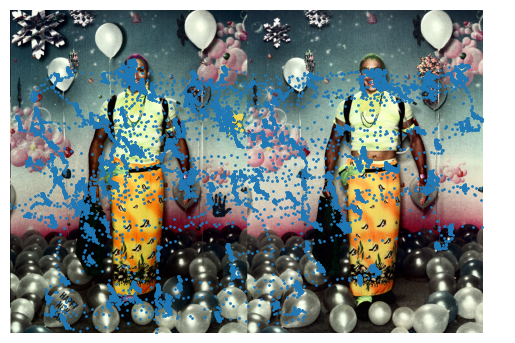

In [4]:
# read the image file
image = plt.imread(image_file)
# turn off axes
plt.axis('off')
plt.imshow(image)

# get only coordinates inside the image
h, w, c = image.shape
print(h, w, c)
df = df[(df["LXpix"] >= 0) & (df["LXpix"] <= w) & (df["LYpix"] >= 0) & (df["LYpix"] <= h)]

# get the coordinates LXpix,LYpix
x = df['LXpix']
y = df['LYpix']

# plot the coordinates
plt.plot(x,y,'o',markersize=1)
plt.axis('off')

The available data table does not classify the movements into saccades and fixation regions. To study this, we must first classify them ourselves. The function for classification is available in utils.py file. For classification the data into saccades and fixation I created an algorithm based on the algorithm availble in this [repository](https://github.com/tmalsburg/saccades). The algorithm uses the following formula to identify saccades in the eye tracking data:

$$\text{saccade} = \left(\frac{v_x}{\text{radius}_x}\right)^2 + \left(\frac{v_y}{\text{radius}_y}\right)^2 > 1$$

Where $v_x$ and $v_y$ are the horizontal and vertical velocities of the eye, respectively, and $\text{radius}_x$ and $\text{radius}_y$ are being calculated from the horizontal and vertical velocities as the square root of the median of the squared velocities minus the median of the velocities squared, multiplied by a value of
$\lambda$.

$$\text{radius}_{x} = \sqrt{\text{median}(v_{x}^2) - \text{median}(v_{x})^2} * \lambda$$
And same for vertical velocity.

The idea behind the algorithm is that during a saccade, the eye moves quickly and erratically. This can be detected by comparing the velocities of the eye to some baseline measure of eye movement. The radii, which are derived from the median standard deviation of the velocities, provide this baseline measure. If the squares of the ratios of the velocities to the radii are greater than 1, this indicates that the eye is moving more quickly than expected based on the radii, and therefore a saccade is likely occurring. See below the example of the output.

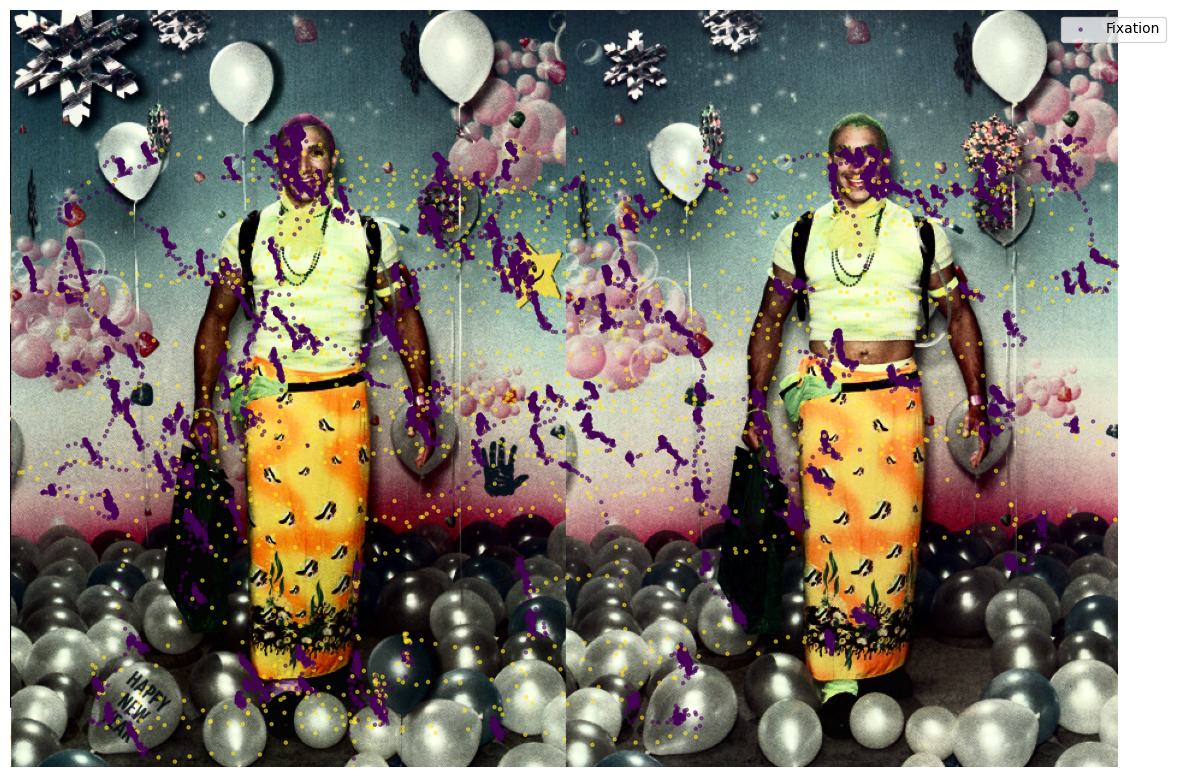

In [5]:
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

df = get_saccades(df, l=10)
df = aggregate_fixations(df)

# plot
plt.figure(figsize=(15, 10))
plt.imshow(image)

plt.scatter(df['LXpix'], df['LYpix'], s=5, c=df['Saccade'], label='Fixation', alpha=0.5)
plt.axis('off')
plt.legend()
plt.show()

We can further characterise individual patterns of saccades and fixations after classifying eye motion into saccades and fixations. 

The variables extracted from the data to characterise individual patterns of saccades and fixations include:

- **`task`**: a list of strings representing the task that the participant was performing (e.g. "puzzle", "natural")
- **`stimulus`**: a list of strings representing the type of visual stimulus that was shown to the participant (e.g. "blank", "puzzle")
- **`n_fixations`**: a list of integers representing the number of fixations made by the participant for each stimulus
- **`fixation_durations`**: a list of floats representing the mean duration of fixations made by the participant for each stimulus
- **`n_saccades`**: a list of integers representing the number of saccades made by the participant for each stimulus
- **`mean_saccade_distances`**: a list of floats representing the mean distance of saccades made by the participant for each stimulus
- **`mean_saccade_durations`**: a list of floats representing the mean duration of saccades made by the participant for each stimulus

This data are further organised into a separate dataframe.

In [6]:
task, stimulus, n_fixations, fixation_durations, n_saccades, mean_saccade_distances, mean_saccade_durations = reorganise_data(csv_image, verbose=False)

# make a dataframe of the results
df = pd.DataFrame({'Task': task, 'Stimulus': stimulus, 'N Fixations': n_fixations, 'Fixation Durations (in sec)': fixation_durations, 'N Saccades': n_saccades, 'Mean Saccade Distances (in pix)': mean_saccade_distances, 'Mean Saccade Durations (in sec)': mean_saccade_durations})
# save the dataframe
df.to_csv('saccades_patterns.csv', index=False)
df

,Task,Stimulus,N Fixations,Fixation Durations (in sec),N Saccades,Mean Saccade Distances (in pix),Mean Saccade Durations (in sec)
0,FreeViewing,Puzzle,93,0.477118,93,220.590992,0.018667
1,Fixation,Natural,4,11.230500,3,143.888169,0.011333
2,Fixation,Natural,17,2.628000,16,122.005986,0.009750
3,FreeViewing,Puzzle,94,0.467809,95,235.609813,0.020021
4,FreeViewing,Natural,60,0.738433,60,75.479113,0.009000
...,...,...,...,...,...,...,...
674,Fixation,Puzzle,24,1.872417,23,50.043558,0.008783
675,Fixation,Puzzle,31,1.447161,30,113.951252,0.017267
676,FreeViewing,Waldo,137,0.321635,138,81.890301,0.012565
677,FreeViewing,Puzzle,132,0.338939,131,195.204124,0.022519


## Does the number of fixations and number of saccades differ if the participant had a task to fixate their gaze?

To test if the number of fixations/saccades differs due to the enforced task, I will use a simple t-test to compare the means of two distributions.

In [2]:
# read the dataframe
df = pd.read_csv("saccades_patterns.csv")
df

,Task,Stimulus,N Fixations,Fixation Durations (in sec),N Saccades,Mean Saccade Distances (in pix),Mean Saccade Durations (in sec)
0,FreeViewing,Puzzle,93,0.477118,93,220.590992,0.018667
1,Fixation,Natural,4,11.230500,3,143.888169,0.011333
2,Fixation,Natural,17,2.628000,16,122.005986,0.009750
3,FreeViewing,Puzzle,94,0.467809,95,235.609813,0.020021
4,FreeViewing,Natural,60,0.738433,60,75.479113,0.009000
...,...,...,...,...,...,...,...
674,Fixation,Puzzle,24,1.872417,23,50.043558,0.008783
675,Fixation,Puzzle,31,1.447161,30,113.951252,0.017267
676,FreeViewing,Waldo,137,0.321635,138,81.890301,0.012565
677,FreeViewing,Puzzle,132,0.338939,131,195.204124,0.022519


t-statistic: -35.99986790664138
p-value: 2.1471782463216036e-159
There is a statistically significant difference in the number of N Fixations between the two tasks.
t-statistic: -35.211585507338
p-value: 3.788674288007556e-155
There is a statistically significant difference in the number of N Saccades between the two tasks.


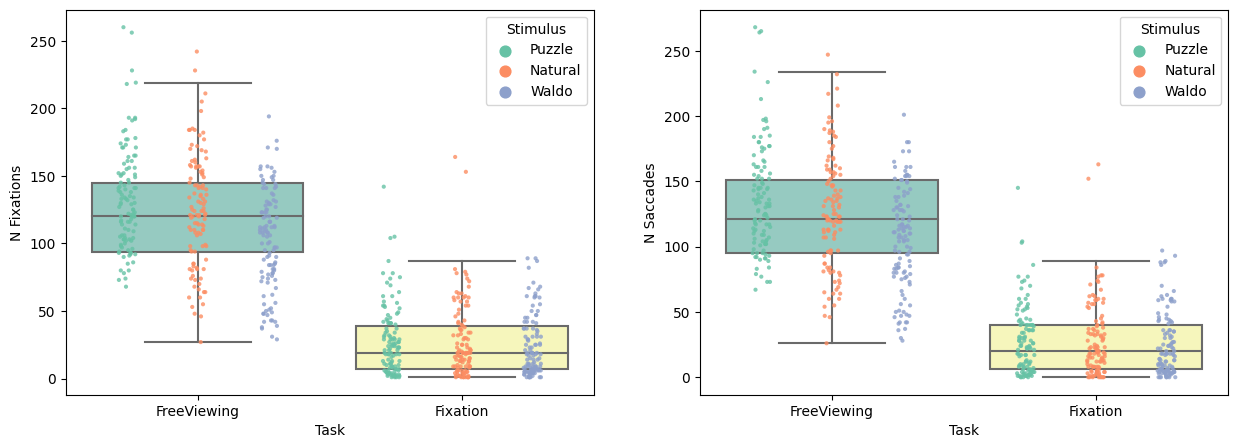

In [3]:
# create a figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

parameters = ["N Fixations", "N Saccades"] # parameters to compare
for i, parameter in enumerate(parameters):
    # Extract the number of fixations/saccades for the "fixation" and "free viewing" tasks
    fixation_task = df[df["Task"] == "Fixation"][parameter]
    free_viewing_task = df[df["Task"] == "FreeViewing"][parameter]

    # Perform a t-test to compare the number of fixations in the two tasks
    t_stat, p_value = stats.ttest_ind(fixation_task, free_viewing_task)

    print("t-statistic:", t_stat)
    print("p-value:", p_value)

    # If the p-value is less than 0.05, we can reject the null hypothesis that the number of fixations is the same in both tasks
    if p_value < 0.05:
        print(f"There is a statistically significant difference in the number of {parameter} between the two tasks.")
    else:
        print(f"There is no statistically significant difference in the number of {parameter} between the two tasks.")

    # Plot the number of fixations/saccades for the two tasks
    sns.boxplot(x="Task", y=parameter, data=df, palette="Set3", showfliers=False, ax=ax[i])
    sns.stripplot(x="Task", y=parameter, data=df, size=3, alpha=0.8, hue="Stimulus", palette="Set2", dodge=True, ax=ax[i])

There is a statistically significant difference between the two tasks in the number of fixations and number of saccades. The t-statistic and p-value for the number of fixations and number of saccades are both very small, indicating a strong statistical significance. This suggests that the two tasks have significantly different numbers of fixations and saccades. However, the result is quite expected and provides little insight into the data, as in the case of the Fixation task, participants were asked not to move their gaze forcefully.

## Does the pattern of saccades vary depending on the stimulus?

We will compare the situation among three groups of different stimuli. To test the statistical significance of the differences among these groups, we will use an ANOVA test followed by a [Tukey's HSD (honestly significant difference) test](https://www.wikiwand.com/en/Tukey%27s_range_test).

There is a statistically significant difference in the given parameter between the different stimuli.
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1 group2 meandiff p-adj   lower    upper   reject
-------------------------------------------------------
Natural Puzzle   9.4951 0.2024  -3.5661  22.5563  False
Natural  Waldo -20.8516 0.0005  -33.825  -7.8782   True
 Puzzle  Waldo -30.3467    0.0 -43.3793 -17.3142   True
-------------------------------------------------------
There is a statistically significant difference in the given parameter between the different stimuli.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Natural Puzzle  -0.0534 0.1139 -0.1163 0.0095  False
Natural  Waldo   0.0947 0.0012  0.0322 0.1572   True
 Puzzle  Waldo   0.1481    0.0  0.0854 0.2109   True
----------------------------------------------------
There is a statistically signific

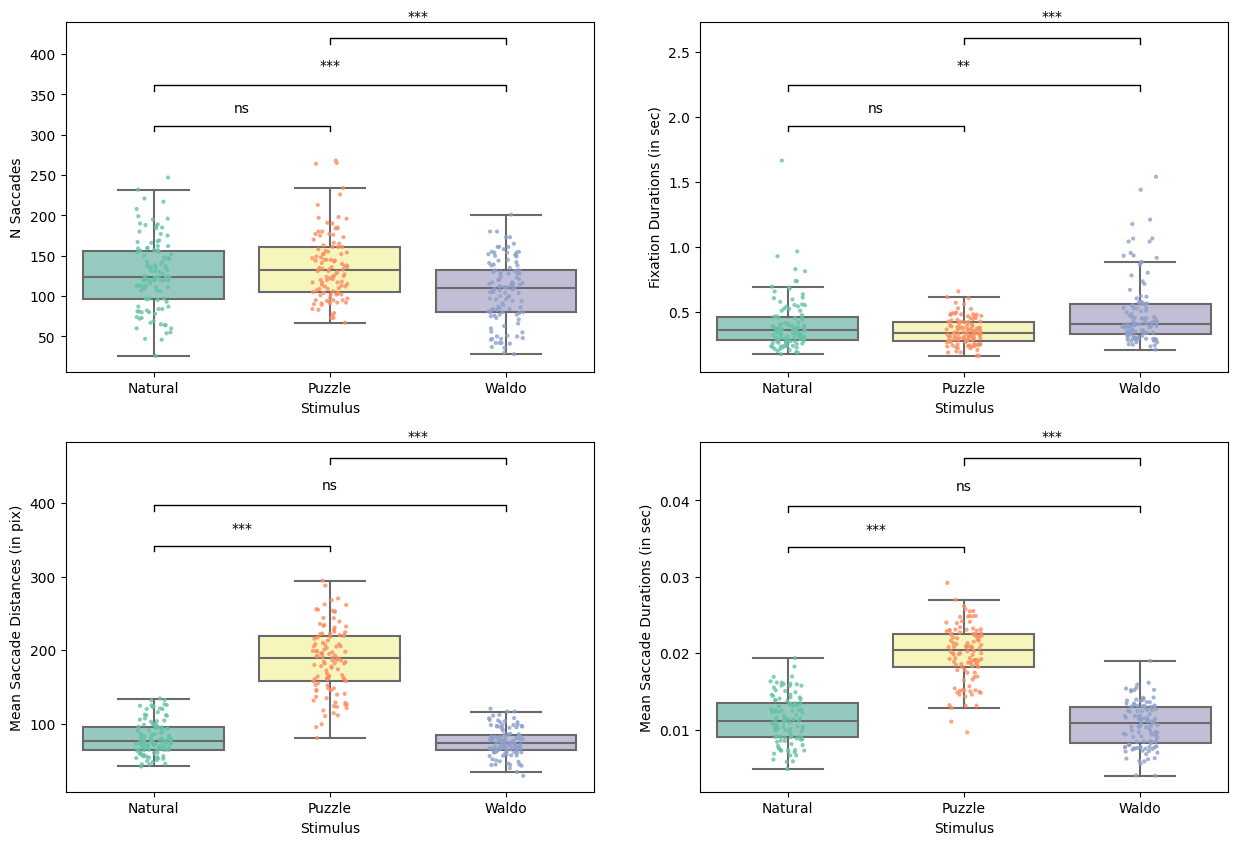

In [4]:
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# create a figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

parameters = ["N Saccades", "Fixation Durations (in sec)", "Mean Saccade Distances (in pix)", "Mean Saccade Durations (in sec)"] # parameters to compare

for parameter, ax in zip(parameters, axes.flatten()):
    # test using ANOVA to compare the parameter between the different stimuli but only for the free viewing task
    fvalue, pvalue = stats.f_oneway(df[df["Task"] == "FreeViewing"][df["Stimulus"] == "Puzzle"][parameter],
                    df[df["Task"] == "FreeViewing"][df["Stimulus"] == "Natural"][parameter],
                    df[df["Task"] == "FreeViewing"][df["Stimulus"] == "Waldo"][parameter])
    
    # If the p-value is less than 0.05, we can reject the null hypothesis that the number of fixations is the same in all stimuli
    if pvalue < 0.05:
        print("There is a statistically significant difference in the given parameter between the different stimuli.")
    else:
        print("There is no statistically significant difference in the given parameter between the different stimuli.")
    
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=df[df["Task"] == "FreeViewing"][parameter], groups=df[df["Task"] == "FreeViewing"]["Stimulus"], alpha=0.05)
    print(m_comp.summary())
    
    # Plot the parameters for the two tasks only for the "free viewing" task
    sns.boxplot(x="Stimulus", y=parameter, data=df[df["Task"] == "FreeViewing"], palette="Set3", showfliers=False, ax=ax, order=m_comp.groupsunique)
    sns.stripplot(x="Stimulus", y=parameter, data=df[df["Task"] == "FreeViewing"], size=3, alpha=0.8, palette="Set2", ax=ax, order=m_comp.groupsunique)
    add_statistical_significance_bars(groups=m_comp.groupsunique, p_values=m_comp.pvalues, ax=ax)

Clearly, the puzzle stimulus is distinct from others in terms of saccade distance and duration. This makes perfect sense, when considering the fact that the participant is asked to compare the left and right sides of the figure to locate the differences among the visually similar images. 

Surprisingly, the exploration of Waldo images is not much different from that of the free viewing of Natural scenes, even though in the case of Waldo, participants are essentially expected to solve a puzzle by locating Waldo in the image. However, this new task of identifying Waldo does not seem to disrupt the viewing process all that much, as the viewing behaviour remains relatively similar to that of free viewing. The difference is however found in terms of fixation duration, given that now participant have to enforce much higher attention to their viewing process. 

The differences in the saccades patterns can be sumarised by dimensionality reduction and observed all together in one plot.

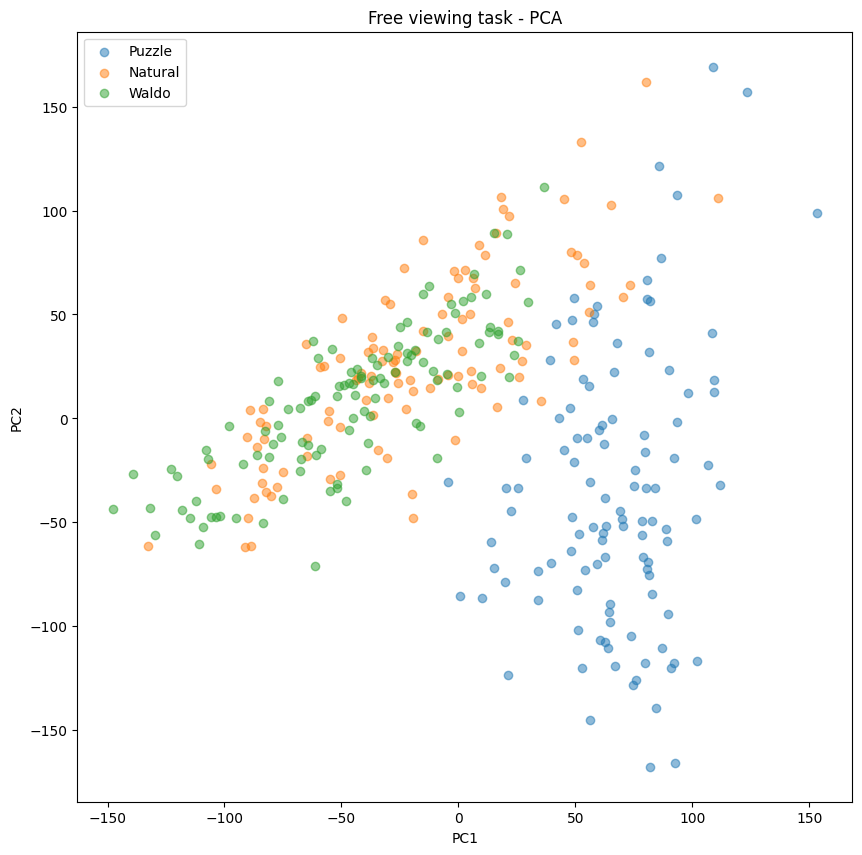

In [7]:

from sklearn.decomposition import PCA
# remove nans from the dataframe
df = df.dropna()
df = df[df["Task"] == "FreeViewing"]

# reduce dimensionality using PCA and plot with hue as stimulus
pca = PCA(n_components=2)
pca.fit(df[['N Fixations', 'Fixation Durations (in sec)', 'N Saccades',
       'Mean Saccade Distances (in pix)', 'Mean Saccade Durations (in sec)']])
X = pca.transform(df[['N Fixations', 'Fixation Durations (in sec)', 'N Saccades',
       'Mean Saccade Distances (in pix)', 'Mean Saccade Durations (in sec)']])
plt.figure(figsize=(10, 10))

for stimulus in df["Stimulus"].unique():
    mask = df["Stimulus"] == stimulus
    plt.scatter(X[mask, 0], X[mask, 1], label=stimulus, alpha=0.5)

plt.legend()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Free viewing task - PCA") 
plt.show()

## Do people's saccade patterns change as they complete a task or become more familiar with a scene?

We hypothesize that learning a scene and becoming familiar with it will affect visual exploration in a meaningful way. We will focus on the learning process in the case of puzzles, such as finding difference puzzles and Waldo puzzles, while using natural images as a control.

Here we are using slightly modified code to extract same data but separated into two time intervals. 0 is for the first 20 seconds, and 1 is for the seconds 25 seconds.

In [129]:
# Reorganise the data to have the time intervals as a column
task, stimulus, n_fixations, fixation_durations, n_saccades, mean_saccade_distances, mean_saccade_durations, time_interval = reorganise_data_with_time_intervals(csv_image, verbose=False)
# Create a dataframe
df = pd.DataFrame({"Task": task, "Stimulus": stimulus, "N Fixations": n_fixations, "Fixation Durations (in sec)": fixation_durations, "N Saccades": n_saccades, "Mean Saccade Distances (in pix)": mean_saccade_distances, "Mean Saccade Durations (in sec)": mean_saccade_durations, "Time Interval": time_interval})
# Save the dataframe to a csv file
df.to_csv("saccades_patterns_time_intervals.csv", index=False)
df.head()

,Task,Stimulus,N Fixations,Fixation Durations (in sec),N Saccades,Mean Saccade Distances (in pix),Mean Saccade Durations (in sec),Time Interval
0,FreeViewing,Puzzle,93,0.477118,36,235.320122,0.020056,0
1,Fixation,Natural,4,11.230500,1,106.722225,0.010000,1
2,FreeViewing,Waldo,78,0.574077,46,69.510722,0.007696,1
3,Fixation,Puzzle,8,5.621500,0,NaN,NaN,0
4,Fixation,Puzzle,8,5.621500,7,12.903337,0.002286,1


In [130]:
# Read the csv file
df = pd.read_csv("free_viewing_with_time_intervals.csv")
# Remove the rows with nan values
df = df.dropna()
# Remove raws with negative values in the "Mean Saccade Durations (in sec)" column and "Fixation Durations (in sec)"" column
df = df[df["Mean Saccade Durations (in sec)"] >= 0]
df = df[df["Fixation Durations (in sec)"] >= 0]
df

,Task,Stimulus,N Fixations,Fixation Durations (in sec),N Saccades,Mean Saccade Distances (in pix),Mean Saccade Durations (in sec),Time Interval
0,FreeViewing,Puzzle,93,0.477118,36,235.320122,0.020056,0
1,Fixation,Natural,4,11.230500,1,106.722225,0.010000,1
2,FreeViewing,Waldo,78,0.574077,46,69.510722,0.007696,1
4,Fixation,Puzzle,8,5.621500,7,12.903337,0.002286,1
5,Fixation,Natural,6,7.491667,1,227.635547,0.020000,1
...,...,...,...,...,...,...,...,...
422,FreeViewing,Waldo,137,0.321635,67,85.812789,0.013164,0
423,FreeViewing,Waldo,137,0.321635,68,77.421964,0.011912,1
424,FreeViewing,Puzzle,132,0.338939,54,205.870619,0.023481,0
425,FreeViewing,Puzzle,132,0.338939,77,187.723725,0.021844,1


Before delving into the details, let's visually explore if the *time interval* can be a useful parameter. We'll use [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to get a quick overview of the data.

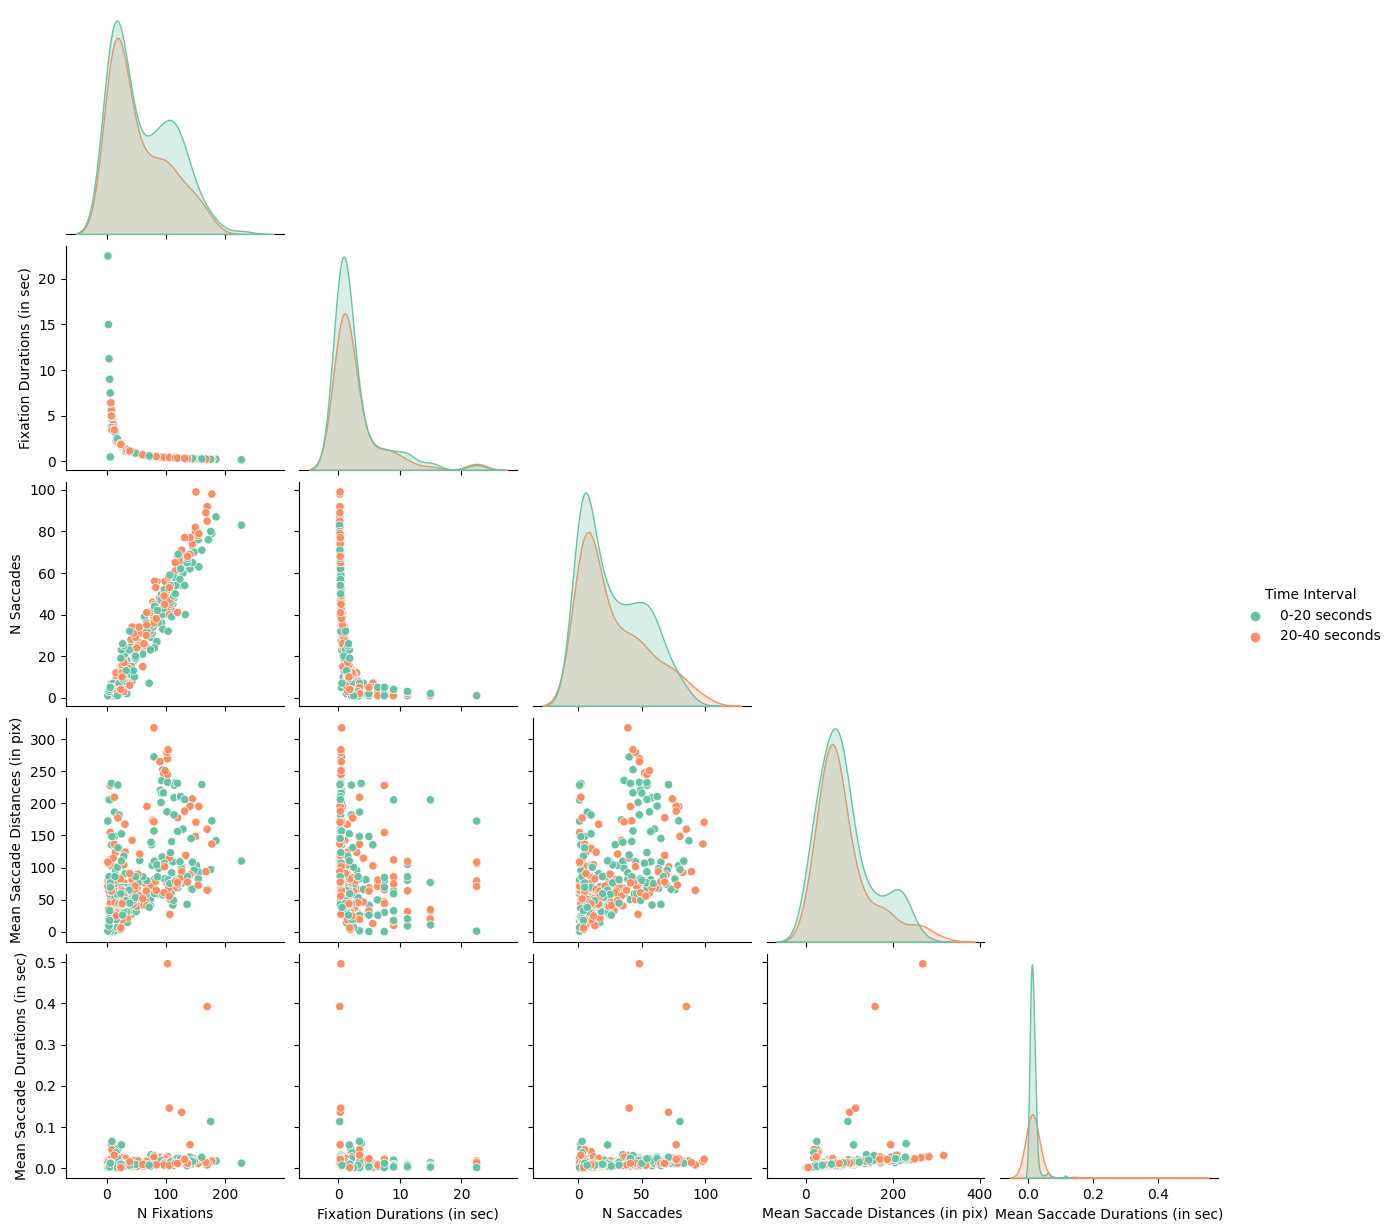

In [131]:
# replace the time interval with names
df['Time Interval'][df['Time Interval']==0] = "0-20 seconds"
df['Time Interval'][df['Time Interval']==1] = "20-40 seconds"
# plot the data with hue as time interval
sns.pairplot(df, hue="Time Interval", palette="Set2", diag_kind="kde", height=2.5, corner=True)

We can notice that the number of Saccades and number of Fixation do not overlay completely for two time intervals. Notice that these data do not distinguish the Stimuli, so we can expect that for Puzzle stimulus the difference will be more significant. We will compute the proportion of fixation to saccades and will explore how it changes with time interval.

In [132]:
# Get proportion of fixation to saccade for each stimulus
df["Proportion Fixation to Saccade"] = df["N Fixations"] / df["N Saccades"]
df

,Task,Stimulus,N Fixations,Fixation Durations (in sec),N Saccades,Mean Saccade Distances (in pix),Mean Saccade Durations (in sec),Time Interval,Proportion Fixation to Saccade
0,FreeViewing,Puzzle,93,0.477118,36,235.320122,0.020056,0-20 seconds,2.583333
1,Fixation,Natural,4,11.230500,1,106.722225,0.010000,20-40 seconds,4.000000
2,FreeViewing,Waldo,78,0.574077,46,69.510722,0.007696,20-40 seconds,1.695652
4,Fixation,Puzzle,8,5.621500,7,12.903337,0.002286,20-40 seconds,1.142857
5,Fixation,Natural,6,7.491667,1,227.635547,0.020000,20-40 seconds,6.000000
...,...,...,...,...,...,...,...,...,...
422,FreeViewing,Waldo,137,0.321635,67,85.812789,0.013164,0-20 seconds,2.044776
423,FreeViewing,Waldo,137,0.321635,68,77.421964,0.011912,20-40 seconds,2.014706
424,FreeViewing,Puzzle,132,0.338939,54,205.870619,0.023481,0-20 seconds,2.444444
425,FreeViewing,Puzzle,132,0.338939,77,187.723725,0.021844,20-40 seconds,1.714286


t-statistic: 2.1349637004833197
p-value: 0.03351155545556303
There is a statistically significant difference in Proportion Fixation to Saccade between the two time intervals.


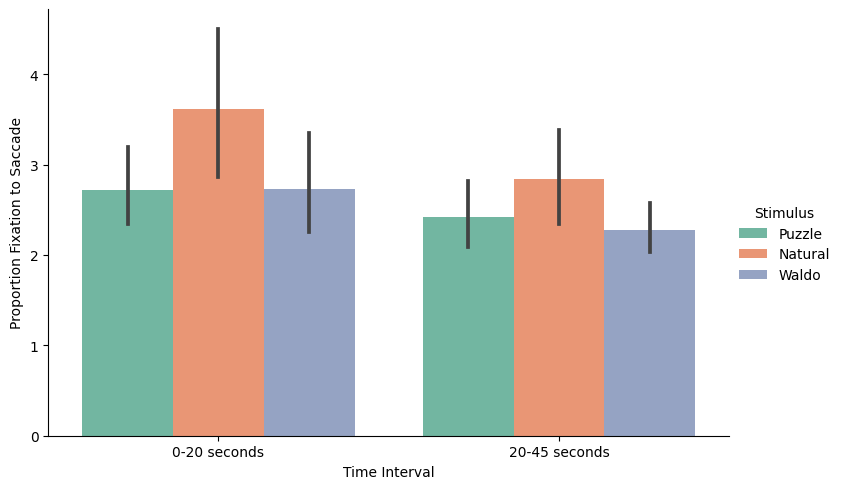

In [133]:
# plot proportion of fixation to saccade for each stimulus and time interval
sns.catplot(x="Time Interval", y="Proportion Fixation to Saccade", data=df, kind="bar", palette="Set2", height=5, aspect=1.5, hue="Stimulus") 

# add x ticks labels
plt.xticks([0, 1], ["0-20 seconds", "20-45 seconds"])

# test using t-test to compare the proportion of fixation to saccade between time intervals but only for the free viewing task

first_interval = df[df["Time Interval"] == '0-20 seconds']["Proportion Fixation to Saccade"]
second_interval = df[df["Time Interval"] == '20-40 seconds']["Proportion Fixation to Saccade"]

# Perform a t-test to compare the number of fixations in the two tasks
t_stat, p_value = stats.ttest_ind(first_interval, second_interval)

print("t-statistic:", t_stat)
print("p-value:", p_value)

# If the p-value is less than 0.05, we can reject the null hypothesis that the number of fixations is the same in both tasks
if p_value < 0.05:
    print(f"There is a statistically significant difference in Proportion Fixation to Saccade between the two time intervals.")
else:
    print(f"There is no statistically significant difference in Proportion Fixation to Saccade between the two time intervals.")

In [136]:
control = df[df["Stimulus"] == "Natural"]
puzzles = df[df["Stimulus"] != "Natural"]

There is no statistically significant difference in Proportion Fixation to Saccade between the two time intervals for Control, p-value: 0.17459400926693214
There is no statistically significant difference in Proportion Fixation to Saccade between the two time intervals for Puzzles, p-value: 0.1049593180763138


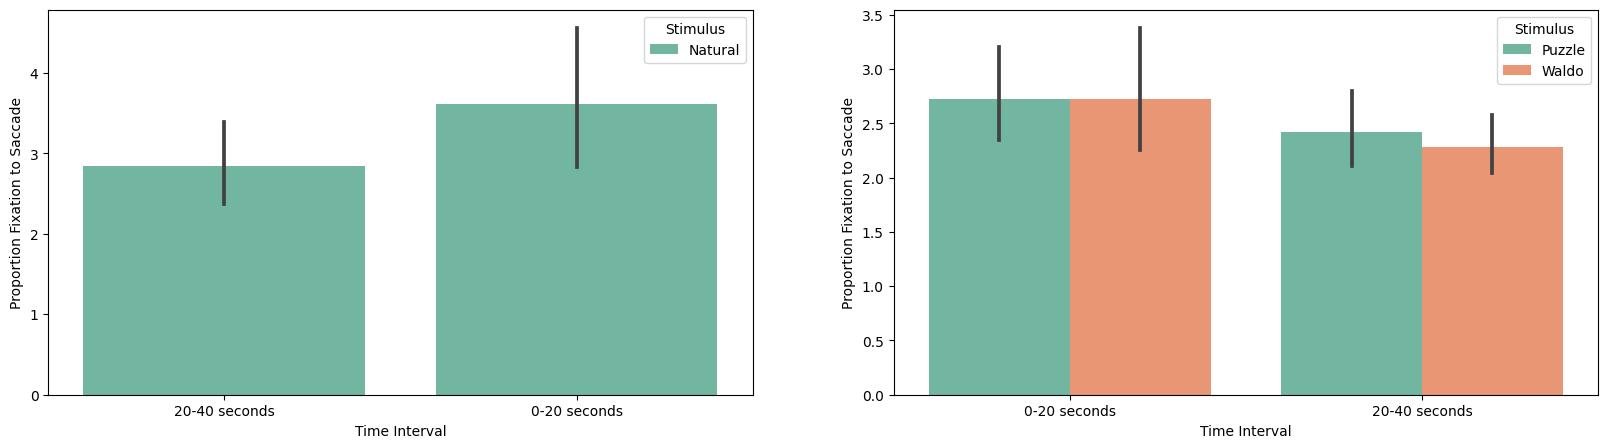

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for i,(df_name, df_type) in enumerate(zip(['Control', 'Puzzles'],[control, puzzles])):

    # plot proportion of fixation to saccade for each stimulus and time interval
    sns.barplot(x="Time Interval", y="Proportion Fixation to Saccade", data=df_type, palette="Set2", hue="Stimulus", ax=ax[i])

    # test using t-test to compare the proportion of fixation to saccade between time intervals but only for the free viewing task

    first_interval = df_type[df_type["Time Interval"] == '0-20 seconds']["Proportion Fixation to Saccade"]
    second_interval = df_type[df_type["Time Interval"] == '20-40 seconds']["Proportion Fixation to Saccade"]

    # Perform a t-test to compare the number of fixations in the two tasks
    t_stat, p_value = stats.ttest_ind(first_interval, second_interval)

    # If the p-value is less than 0.05, we can reject the null hypothesis that the number of fixations is the same in both tasks
    if p_value < 0.05:
        print(f"There is a statistically significant difference in Proportion Fixation to Saccade between the two time intervals for {df_name}, p-value: {p_value}")
    else:
        print(f"There is no statistically significant difference in Proportion Fixation to Saccade between the two time intervals for {df_name}, p-value: {p_value}")

All stimuli taken together, we see a difference between time intervals. However, when we compare it with regard to stimulus, the significance disappears. In general, it seems that learning affects how we proceed with visual exploration. Specifically, the amount of fixation decreases as we study the image more and more, regardless of the visual stimuli being observed. As we will show below, this process is accompanied by an increase in the durations of these fixations (although not statistically significant). This suggests that more attention is dedicated to certain areas instead of just fast image scanning.

t-statistic: -0.4170308549312079
p-value: 0.6769311625035639
There is no statistically significant difference in Fixation Durations (in sec) between the two time intervals.


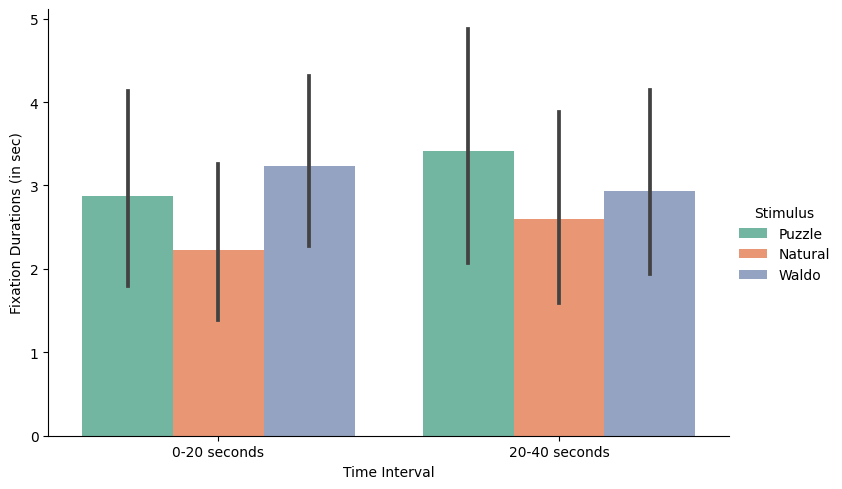

In [141]:
# plot proportion of fixation to saccade for each stimulus and time interval
sns.catplot(x="Time Interval", y="Fixation Durations (in sec)", data=df, kind="bar", palette="Set2", height=5, aspect=1.5, hue="Stimulus") 

# test using t-test to compare the proportion of fixation to saccade between time intervals but only for the free viewing task

first_interval = df[df["Time Interval"] == '0-20 seconds']["Fixation Durations (in sec)"]
second_interval = df[df["Time Interval"] == '20-40 seconds']["Fixation Durations (in sec)"]

# Perform a t-test to compare the number of fixations in the two tasks
t_stat, p_value = stats.ttest_ind(first_interval, second_interval)

print("t-statistic:", t_stat)
print("p-value:", p_value)

# If the p-value is less than 0.05, we can reject the null hypothesis that the number of fixations is the same in both tasks
if p_value < 0.05:
    print(f"There is a statistically significant difference in Fixation Durations (in sec) between the two time intervals.")
else:
    print(f"There is no statistically significant difference in Fixation Durations (in sec) between the two time intervals.")